In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
pd.options.mode.chained_assignment = None  # default='warn'
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot

Let's load in the data into a dataframe!

In [2]:
con = sqlite3.connect('mental_health.sqlite')
qna = """
SELECT * from Answer inner join Question on 
Answer.QuestionID=Question.questionid
"""
#sort by userID
qna_df = pd.read_sql_query(qna, con, index_col = 'UserID').sort_index()
#remove the unnecessary columns
qna_df = qna_df[['SurveyID', 'questiontext', 'AnswerText', 'questionid']]

Examine the gender of our data

In [3]:
#graph the demographic of data set
gender = qna_df[qna_df['questiontext'] == 'What is your gender?']
#clean up gender data to 3 categories
gender.loc[gender['AnswerText'] == 'male', ['Gender']] = 'Male'
gender.loc[gender['AnswerText'] == 'Male', ['Gender']] = 'Male'
gender.loc[gender['AnswerText'] == 'female', ['Gender']] = 'Female'
gender.loc[gender['AnswerText'] == 'Female', ['Gender']] = 'Female'
gender.loc[(gender['AnswerText'] != 'Female') & (gender['AnswerText'] !='female') &
           (gender['AnswerText'] !='male') & (gender['AnswerText'] !='Male'),
           ['Gender']] = 'Other'

#graph subplots of gender data for each year
def graph_by_year(gender, year):
    #get rid of vaccinations unrelated to current year
    current = gender.copy(deep=True)
    current = current[current['SurveyID'].isin([year])]
    labels = ['Male', 'Female', 'Others']
    count = current['Gender'].value_counts()
    values  = [count['Male'], count['Female'], count['Other']]
    gender_fig = px.pie(current, names = labels, values = values, title = 'Gender Distribution of data in '+
                        str(year), color_discrete_sequence=px.colors.qualitative.Pastel)
    gender_fig.show()

In [4]:
#graph the gender data for each year
for year in range (2014, 2020):
    if year == 2015:
        continue
    #graph_by_year(gender, year)

From these graphs, we see that the majority of people who took this survey are men. An interesting note is that the 'Other' category is increasing as the industry becomes more progressive!

Now, let's take a look at the age:

In [5]:
#visualize age data distribution
age = qna_df[qna_df['questiontext'] == 'What is your age?']
age['AnswerText']=age['AnswerText'].astype(int)
age.sort_values(by = ['AnswerText'])
age = age.loc[(age.AnswerText <80) & (age.AnswerText > 18) ]
age_data = px.histogram(age, x = 'AnswerText')
#age_data.show()

Next, let's checkout which countries does the data come from:

In [6]:
#country data
country = qna_df[qna_df['questiontext'] == 'What country do you live in?']
country.loc[country['AnswerText'] == 'United States of America', ['AnswerText']] = 'United States'
#sort the sympotoms by frequency of appearance
country['Freq']= country.groupby('AnswerText')['AnswerText'].transform ('count')
country.sort_values('Freq', inplace=True, ascending=False)

#remove the less common symptoms
country = country.drop(country[country.Freq < 50].index)
country['Country'] = country['AnswerText']

In [7]:
#graph out the most common side effects
country_graph = px.histogram(country['Country'],title = 'Demographic by country', x = 'Country',color_discrete_sequence=px.colors.qualitative.Pastel)
#country_graph.show()

The final determining factor that will be examined is the size of organization:

In [8]:
#clean the data for graph
size = qna_df[qna_df['questionid'] == 8]
size['Size'] = size['AnswerText']
size = size[size.Size != '-1']

In [9]:
#graph out the most common side effects
size_graph = px.histogram(size['Size'],title = 'Size of Organization', 
                          x = 'Size',color_discrete_sequence=px.colors.qualitative.Pastel,
                         category_orders = {'Size':['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']})
#size_graph.show()

After understanding the data we have a little more in terms of its demongraphic, let's examine the trends of mental health services at the workplace over time (2014-2019)

In [10]:
coverage = qna_df[qna_df['questionid'] == 10]
cov_df = pd.DataFrame(columns = ['Year', 'Coverage'])

#calculate the percentage of reports of mental health services present
def calculate_cov(coverage, cov_df,  year, counter):
    current = coverage.copy(deep=True)
    current = current[current['SurveyID'].isin([year])]
    dist = current['AnswerText'].value_counts(normalize = True)*100
    cov_df.loc[counter]= [str(year)]+[dist['Yes']]
counter = 0
for year in range (2014, 2020):
    if year == 2015:
        continue
    calculate_cov(coverage, cov_df, year, counter)
    counter+=1

In [11]:
#show the coverage percentage change with line graph
coverage_graph = px.line(cov_df, x = 'Year', y= 'Coverage', title = 'Percentage of Companies with Mental Health Coverage')
#coverage_graph.update_traces(mode='markers+lines')
#coverage_graph.show()

Does the workplace welcome and accept open conversation about mental health? Let's see the willingness to dicuss these issues with coworkers or supervisors:

In [12]:
coworker_disc = qna_df[qna_df['questionid'] == 99]
age_disc = age[age['SurveyID'].isin([2014])]
coworker_disc ['age'] = age_disc['AnswerText']
coworker_disc['Willingness'] = coworker_disc['AnswerText']
#do calculations to make a categorical scatter/box plot
coworker_disc.loc[coworker_disc['Willingness'] == 'Yes', ['Willingness']] = 'Yes'
coworker_disc.loc[coworker_disc['Willingness'] == 'Some of them', ['Willingness']] = 'Some'
coworker_disc.loc[coworker_disc['Willingness'] == 'No', ['Willingness']] = 'No'
coworker_disc = coworker_disc[['Willingness', 'age']]
coworker_disc = coworker_disc.groupby(['Willingness', 'age']).size().reset_index(name="Freq")

In [13]:
#plot on bubble chart
coworker_graph = px.scatter(coworker_disc, x = 'age', y = 'Willingness', size = 'Freq',color_discrete_sequence=px.colors.qualitative.Pastel)
#coworker_graph.show()

In comparison to supervisor?

In [14]:
sup_disc = qna_df[qna_df['questionid'] == 100]
sup_disc ['age'] = age_disc['AnswerText']
sup_disc['Willingness'] = sup_disc['AnswerText']
#do calculations to make a categorical scatter/box plot
sup_disc.loc[sup_disc['Willingness'] == 'Yes', ['Willingness']] = 'Yes'
sup_disc.loc[sup_disc['Willingness'] == 'Some of them', ['Willingness']] = 'Some'
sup_disc.loc[sup_disc['Willingness'] == 'No', ['Willingness']] = 'No'
sup_disc = sup_disc[['Willingness', 'age']]
sup_disc = sup_disc.groupby(['Willingness', 'age']).size().reset_index(name="Freq")

In [15]:
#plot on bubble chart
sup_graph = px.scatter(sup_disc, x = 'age', y = 'Willingness', size = 'Freq',color_discrete_sequence=px.colors.qualitative.Pastel)
#sup_graph.show()

By comparing the two, we can see that a lot more people are more comfortable with talking to supervisors than coworkers. At the same time, more people are not willing to talk to their supervisors. This reveals that not all

In [16]:
imp = qna_df[qna_df['questionid'] == 65]
health = qna_df[qna_df['questionid'] == 64]
health ['HealthRating'] = health['AnswerText']
imp ['MentalRating'] = imp ['AnswerText']
imp['MentalRating']=imp['MentalRating'].astype(int)
health['HealthRating']=health['HealthRating'].astype(int)
imp = imp.groupby(['MentalRating']).size().reset_index(name = 'Freq_mental')
health = health.groupby(['HealthRating']).size().reset_index(name = 'Freq_physical')
imp ['Freq_physical'] = health['Freq_physical']
#drop NA cases
imp = imp.drop([0,1])
imp_fig = px.bar(imp, x= 'MentalRating', y= ['Freq_mental','Freq_physical'], barmode = 'group', title = 'Mental vs. Physical Health Importance'
                 ,color_discrete_sequence=px.colors.qualitative.Pastel)
#imp_fig.show()

As shown in the graph, it is clear that most companies place more importance on physical health in comparison to mental.

Now, let's take a look at whether those in tech feel like they will receive negative consequences for speaking up about mental health with respect to the size of the company: 

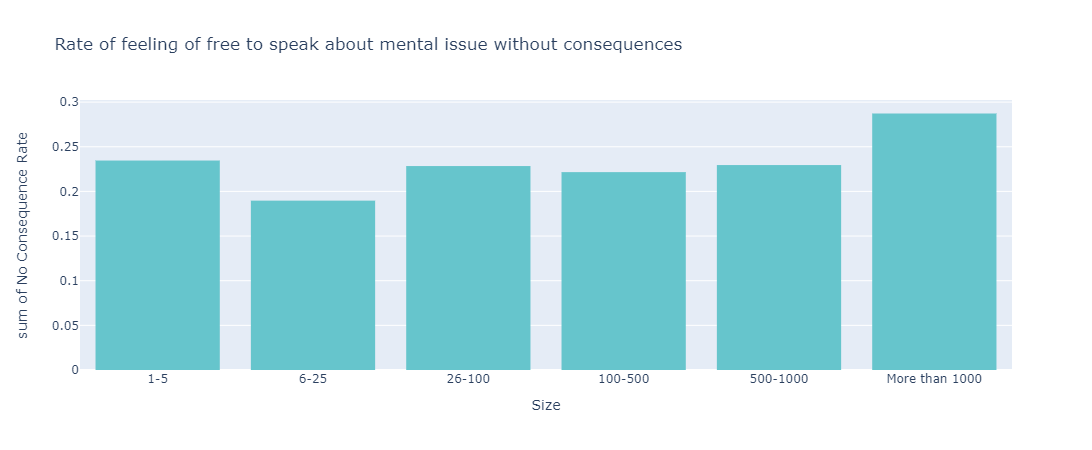

In [35]:
neg = qna_df[qna_df['questionid'] == 98]
neg['Size'] = size ['Size']
#combine the two dfs to find the frequency of duplicate situations
neg = neg.groupby (['Size', 'AnswerText']).size().reset_index(name="Freq")
neg_df = pd.DataFrame(columns = ['Size', 'No Consequence Rate'])

#Calculate the percentage of people who voted 'No'
index = 0
for counter in range (0, 18, 3):
    total = neg['Freq'][counter] + neg['Freq'][counter+1] + neg['Freq'][counter+2]
    rate = neg['Freq'][counter+2] /total
    neg_df.loc [index] = [neg['Size'][counter]]+[rate]
    index +=1

#graph out the results
neg_graph = px.histogram(neg_df, title = 'Rate of feeling of free to speak about mental issue without consequences', 
                          x = 'Size',y ='No Consequence Rate' ,color_discrete_sequence=px.colors.qualitative.Pastel,
                         category_orders = {'Size':['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']})
neg_graph.show()

Although there is a slight increase of satisfaction when the organization is large, there is no obvious trend between these two factors. 